In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time
import itertools

import sklearn.pipeline
import sklearn.preprocessing

# Approximates feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.
# https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html
from sklearn.kernel_approximation import RBFSampler 

In [0]:
class RunningStats(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    # https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.std = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        
        new_mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        new_var = M2 / (self.count + batch_count)

        self.mean = new_mean
        self.var = new_var
        self.std = np.maximum(np.sqrt(self.var), 1e-6)
        self.count = batch_count + self.count

In [0]:
class PPO(object):            
    def __init__(self, sess):
        self.sess = sess
        self.s = tf.placeholder(tf.float32, [None, S_DIM], 'state')
        self.s_ = tf.placeholder(tf.float32, [None, next_S_DIM], 'state_')
        
        # RDN        
        with tf.variable_scope('target'):
            w_init = tf.random_normal_initializer            
            # Fixed target network encodes state to features        
            # Network randomly initialized but never trained, params remain fixed, trainable=False           
            self.target_out = tf.layers.dense(self.s_, encode_features, kernel_initializer=w_init, name='target_out', trainable=False)
        # predictor network
        with tf.variable_scope('predictor'):
            self.predictor_out = tf.layers.dense(self.s_, encode_features, name='predictor_out', trainable=True)
            
            # self.predictor_loss is also the intrinsic reward
            self.predictor_loss = tf.reduce_sum(tf.square(self.target_out - self.predictor_out), axis=1)

        # critic
        with tf.variable_scope('critic'):
            self.v = tf.layers.dense(self.s, 1, name='val', trainable=True)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            
            # critic network for intrinsic reward
            self.v_i = tf.layers.dense(self.s, 1, name='val_i', trainable=True)                      
            self.tfdc_r_i = tf.placeholder(tf.float32, [None, 1], 'discounted_r_i')
            self.advantage_i = self.tfdc_r_i - self.v_i
            self.closs_i = tf.reduce_mean(tf.square(self.advantage_i))
            
            self.total_closs = self.closs + self.closs_i
            
        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=True) # trainable=False
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0) # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
                self.aloss = -tf.reduce_mean(tf.minimum(surr,
                                                        tf.clip_by_value(ratio, 1.-epsilon, 1.+epsilon)*self.tfadv))

        with tf.variable_scope('entropy'):                
            entropy = -tf.reduce_mean(pi.entropy()) # Compute the differential entropy of the multivariate normal.                   
                            
        with tf.variable_scope('total_loss'):
            self.total_loss = tf.reduce_mean(self.predictor_loss) + self.total_closs + self.aloss
                                    
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(TL_LR).minimize(self.total_loss, #+ entropy * ENTROPY_BETA, 
                                                                   global_step=tf.train.get_global_step())

            self.sess.run(tf.global_variables_initializer())
            
    def update(self, s, s_, a, r, r_i, adv):
        if state_ftr == True:
            s = featurize_batch_state(s)
        
        self.sess.run(self.update_oldpi_op)
        
        # update actor
        [self.sess.run(self.train_op, {self.s: s, self.tfa: a, self.tfadv: adv, self.tfdc_r: r, self.tfdc_r_i: r_i, self.s_: s_}) for _ in range(A_UPDATE_STEPS)]
            
    def _build_anet(self, name, trainable):
        # tanh range = [-1,1]
        # softplus range = {0,inf}
        with tf.variable_scope(name):
            # note that not initializing weights results in nan outputs which happens randomly 
            # most likely caused by exploding gradients
            mu = tf.layers.dense(self.s, A_DIM, tf.nn.tanh, kernel_initializer = tf.random_normal_initializer, name='mu', trainable=trainable) 
            sigma = tf.layers.dense(self.s, A_DIM, tf.nn.softplus, kernel_initializer = tf.random_normal_initializer, name='sigma', trainable=trainable) + 1e-4
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.s: s})[0]            
        return np.clip(a, env.action_space.low[0], env.action_space.high[0])

    def get_v(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.s: s})[0, 0]
      
    def get_v_i(self, s):
        if state_ftr == True:
          s = featurize_state(s)
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v_i, {self.s: s})[0, 0]
      
    def intrinsic_r(self, s_):
        return self.sess.run(self.predictor_loss, {self.s_: s_})      
      
    def add_vtarg_and_adv(self, R, done, V, v_s_, gamma, lam):
        # Compute target value using TD(lambda) estimator, and advantage with GAE(lambda)
        # last element is only used for last vtarg, but we already zeroed it if last new = 1
        done = np.append(done, 0)
        V_plus = np.append(V, v_s_)
        T = len(R)
        adv = gaelam = np.empty(T, 'float32')
        lastgaelam = 0
        for t in reversed(range(T)):
            nonterminal = 1-done[t+1]        
            delta = R[t] + gamma * V_plus[t+1] * nonterminal - V_plus[t]
            gaelam[t] = lastgaelam = delta + gamma * lam * nonterminal * lastgaelam   
        tdlamret = np.vstack(adv) + V
        return tdlamret, adv # tdlamret is critic_target or Qs         

In [0]:
tf.reset_default_graph()

EP_MAX = 300 #500
EP_LEN = 128 #200 128

GAMMA = 0.95 # discount factor for extrinsic reward
GAMMA_i = 0.95 # discount factor for intrinsic reward

lamda = 0.95 #0.95

hidden = 100 #100 50 128
encode_features = 10000 # 5000 1000 100

ENTROPY_BETA = 0.9 #0.1

TL_LR = 0.001 

BATCH = 10 
A_UPDATE_STEPS = 10 #10 4
C_UPDATE_STEPS = 10 #10 4
epsilon = 0.1

sample_size = 10000 # 10000
n_comp = 100

next_s_CLIP = 1
r_CLIP = 1

epsilon=0.2

state_ftr = True
if state_ftr == True:
    S_DIM, next_S_DIM, A_DIM = n_comp*4, 2, 1 # MountainCarContinuous-v0, featurize s only   
else:    
    S_DIM, next_S_DIM, A_DIM = 2, 2, 1 # MountainCarContinuous-v0, not featurize
    
state_next_normal = True # normalize s_ for RDN's target & predictor networks

In [0]:
start_time = time.time()

env = gym.make('MountainCarContinuous-v0')

In [0]:
# pre-train updating of s_ to running_stats_s_ object to get prepare for normalization
def state_next_normalize(sample_size, running_stats_s_):
  
  buffer_s_ = []
  s = env.reset()  
  for i in range(sample_size):
    a = env.action_space.sample()
    s_, r, done, _ = env.step(a)
    buffer_s_.append(s_)
    
  running_stats_s_.update(np.array(buffer_s_))

In [0]:
if state_ftr == True:
    # Feature Preprocessing: Normalize to zero mean and unit variance
    # We use a few samples from the observation space to do this
    states = np.array([env.observation_space.sample() for x in range(sample_size)]) # pre-trained, states preprocessing
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(states) # Compute the mean and std to be used for later scaling.

    # convert states to a featurizes representation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = sklearn.pipeline.FeatureUnion([ # Concatenates results of multiple transformer objects.       
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_comp)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_comp)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_comp)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_comp))      
            ])
    featurizer.fit(
        scaler.transform(states)) # Perform standardization by centering and scaling

    # state featurization of state(s) only, 
    # not used on s_ for RDN's target & predictor networks
    def featurize_state(state):     
        scaled = scaler.transform([state]) # Perform standardization by centering and scaling                    
        featurized = featurizer.transform(scaled) # Transform X separately by each transformer, concatenate results.
        return featurized[0]
    
    def featurize_batch_state(batch_states):
        fs_list = []
        for s in batch_states:
            fs = featurize_state(s)
            fs_list.append(fs)    
        return fs_list   

In [0]:
# unused mv avg function
def mv_avg_fun(X, n):
    if len(X) == 0:
        return 0
    k = np.ones((n,))/n
    mv_avg = np.convolve(X, k, mode='valid')
    return mv_avg

In [0]:
# normalize & clip a running buffer
# used on extrinsic reward (buffer_r), intrinsic reward (buffer_r_i) & next state(s_)
def running_stats_fun(run_stats, buf, clip):
    run_stats.update(np.array(buf))
    val = (np.array(buf) - run_stats.mean) / run_stats.std
    
    if np.any(np.isnan(val)): 
        print('isnan', np.where(np.isnan(val)))
        print('val', val)
        val = np.nan_to_num(val) # replace nan with zero and inf with finite numbers"        
        print('val', val)    
    
    buf = np.clip(val, -clip, clip)
    return buf

In [0]:
sess = tf.Session()  
global_step = tf.Variable(0, name="global_step", trainable=False)
ppo = PPO(sess)
all_steps = [] # stores number of episodic steps for display
all_ep_r = [] # stores raw episodic rewards for display
mv_all_ep_r = [] # store moving average episodic rewards for display

# normalization objects
running_stats_s_ = RunningStats()
running_stats_r = RunningStats()
running_stats_r_i = RunningStats()

hit_counter = 0 # number of times flag reached by agent
sess.run(tf.global_variables_initializer())

W0630 16:51:21.647326 139698975704960 deprecation.py:323] From <ipython-input-3-11891da96ad4>:13: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0630 16:51:21.994724 139698975704960 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0630 16:51:22.297057 139698975704960 deprecation.py:323] From <ipython-input-3-11891da96ad4>:109: Normal.__init__ (from tensorflow.python.ops.distributions.normal) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/

In [0]:
if state_next_normal == True:
  state_next_normalize(sample_size, running_stats_s_)

In [0]:
for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
    ep_r = 0
    steps = 0
    for t in itertools.count():    # in one episode
        #env.render()        
          
        a = ppo.choose_action(s)
        s_, r, done, _ = env.step(a)
                
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append(r)    
        buffer_s_.append(s_)
        buffer_done.append(done)                  
        
        v = ppo.get_v(s)
        buffer_V.append(v)  
        v_i = ppo.get_v_i(s)
        buffer_V_i.append(v_i)  
        
        s = s_
        ep_r += r
        steps += 1                            
        
        # update ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            
            if state_next_normal == True:
                # Batch normalize of running s_ (next state)                                
                # note that s (state) is not normalize
                buffer_s_ = running_stats_fun(running_stats_s_, buffer_s_, next_s_CLIP)
                
            # compute batch r_i
            buffer_r_i = ppo.intrinsic_r(buffer_s_)            
            # Batch normalize running extrinsic r
            buffer_r = running_stats_fun(running_stats_r, buffer_r, r_CLIP)            
            # Batch normalize running intrinsic r_i
            buffer_r_i = running_stats_fun(running_stats_r_i, buffer_r_i, r_CLIP)
            
            v_s_ = ppo.get_v(s_)                                 
            tdlamret, adv = ppo.add_vtarg_and_adv(np.vstack(buffer_r), 
                                                  np.vstack(buffer_done), 
                                                  np.vstack(buffer_V), 
                                                  v_s_, 
                                                  GAMMA, 
                                                  lamda)
            v_s_i = ppo.get_v_i(s_)                     
            tdlamret_i, adv_i = ppo.add_vtarg_and_adv(np.vstack(buffer_r_i),
                                                      np.vstack(buffer_done), 
                                                      np.vstack(buffer_V_i), 
                                                      v_s_i, 
                                                      GAMMA_i, 
                                                      lamda)

            bs, bs_, ba, br, br_i, b_adv = np.vstack(buffer_s), np.vstack(buffer_s_), np.vstack(buffer_a), tdlamret, tdlamret_i, np.vstack(adv + adv_i)
            buffer_s, buffer_a, buffer_r, buffer_s_, buffer_done, buffer_V, buffer_V_i = [], [], [], [], [], [], []
            ppo.update(bs, bs_, ba, br, br_i, b_adv)
            
        if done:            
            print('done', steps, ep) 
            if r > 0:
                hit_counter += 1
                print('********** r > 0 **********', hit_counter, hit_counter / (ep+1), ep, ep_r, ENTROPY_BETA)
                if ENTROPY_BETA > 0.01:
                    ENTROPY_BETA = ENTROPY_BETA * 0.9
            break    

    if ep == 0: 
        mv_all_ep_r.append(ep_r)
    else: 
        mv_ep_r = mv_all_ep_r[-1]*0.9 + ep_r*0.1
        print('          mv_ep_r', mv_ep_r)        
        mv_all_ep_r.append(mv_ep_r)       
      
    all_ep_r.append(ep_r)      
    all_steps.append(steps)                

done 999 0
done 588 1
********** r > 0 ********** 1 0.5 1 48.302013337328724 0.9
          mv_ep_r -59.630315689623814
done 999 2
          mv_ep_r -63.24335567424301
done 999 3
          mv_ep_r -66.42509503241199
done 999 4
          mv_ep_r -69.22000214284311
done 553 5
********** r > 0 ********** 2 0.3333333333333333 5 48.08064525387408 0.81
          mv_ep_r -57.489937403171396
done 999 6
          mv_ep_r -61.142527430411576
done 895 7
********** r > 0 ********** 3 0.375 7 18.009570928102207 0.7290000000000001
          mv_ep_r -53.2273175945602
done 999 8
          mv_ep_r -57.07312270294025
done 999 9
          mv_ep_r -60.54390044991527
done 999 10
          mv_ep_r -63.64179197564473
done 849 11
********** r > 0 ********** 4 0.3333333333333333 11 22.225585389319818 0.6561000000000001
          mv_ep_r -55.05505423914827
done 481 12
********** r > 0 ********** 5 0.38461538461538464 12 56.53211630195809 0.5904900000000002
          mv_ep_r -43.89633718503764
done 336 13
*******

hit_counter 291 0.97


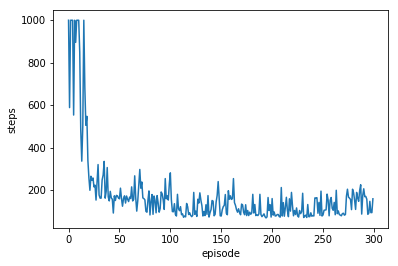

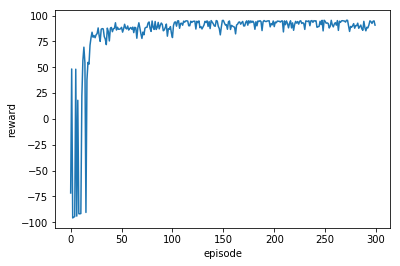

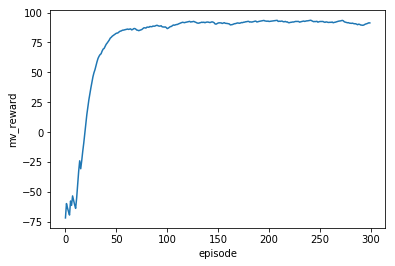

--- 385.09387278556824 seconds ---


In [0]:
print('hit_counter', hit_counter, hit_counter/EP_MAX)    

plt.plot(all_steps)
plt.ylabel("steps")
plt.xlabel("episode")
plt.show()

plt.plot(all_ep_r)
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

plt.plot(mv_all_ep_r)
plt.ylabel("mv_reward")
plt.xlabel("episode")
plt.show()

print("--- %s seconds ---" % (time.time() - start_time))    